In [1]:
import torch
from torch import nn
from torchtext.datasets import IMDB
import torchtext; torchtext.disable_torchtext_deprecation_warning()
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))

import re

c:\Users\rain\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\rain\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rain\AppData

In [2]:
data = pd.read_csv("archive/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
from tqdm import tqdm
tqdm.pandas()
def transform_label(label):
    return 1 if label == 'positive' else 0

data["label"] = data["sentiment"].progress_apply(transform_label)
data.head()
data.sentiment.value_counts()

100%|██████████| 50000/50000 [00:00<00:00, 1269831.43it/s]


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [4]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))
data_pos = data[data['label'] == 1]
data_pos['token_length'].describe()

100%|██████████| 50000/50000 [00:00<00:00, 123869.89it/s]


count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [5]:
data_neg = data[data['label'] == 0]
data_neg['token_length'].describe()

count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

#### Cleaning

In [6]:


def rm_links(text):
    return re.sub(r'https?://\S+', '', text)
def rm_punct2(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

def rm_number(text):
    return re.sub(r'\d+', '', text)

def rm_whitespaces(text):
    return re.sub(r' +', ' ', text)

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

# add whitespaces between punctuation and remove double whitespaces
def space_bt_punct(text):
    pattern = r'([.,!?-])'
    s = re.sub(pattern, r' \1 ', text)
    s = re.sub(r'\s{2,}', ' ', s)
    return s

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

def spell_correction(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):
    no_link = rm_links(text)
    no_html = rm_html(no_link)
    space_punct = space_bt_punct(no_html)
    no_punct = rm_punct2(space_punct)
    no_number = rm_number(no_punct)
    no_whitespaces = rm_whitespaces(no_number)
    no_nonasci = rm_nonascii(no_whitespaces)
    no_emoji = rm_emoji(no_nonasci)
    spell_corrected = spell_correction(no_emoji)
    return spell_corrected

#### Preprocessing

In [9]:


def tokenize(text):
    return nltk.word_tokenize(text) # separate words

def rm_stopwords(text): # remove common stopwords from the tokenized text
    return [i for i in text if i not in stopwords]

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(t) for t in text]
    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize(no_stopwords)
    return ' '.join(lemmas)

In [10]:
data['clean'] = data['review'].progress_apply(clean_pipeline)
data['processed'] = data['clean'].progress_apply(preprocess_pipeline)
data.head()

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:58<00:00, 848.34it/s]


,review,sentiment,label,token_length,clean,processed
0,One of the other reviewers has mentioned that ...,positive,1,307,One of the other reviewers has mentioned that ...,One reviewer mentioned watching Oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,1,162,A wonderful little production . The filming te...,A wonderful little production . The filming te...
2,I thought this was a wonderful way to spend ti...,positive,1,166,I thought this was a wonderful way to spend ti...,I thought wonderful way spend time hot summer ...
3,Basically there's a family where a little boy ...,negative,0,138,Basically there s a family where a little boy ...,Basically family little boy Jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,Petter Mattei s Love in the Time of Money is a...,Petter Mattei Love Time Money visually stunnin...


In [11]:
data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)

#### Transfer text into vector

In [16]:
data = pd.read_csv("imdb_processed.csv")
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [19]:
reviews = data.processed.values # get all processed revies
words = ' '.join(reviews) # merge into single variable separated by whitespaces
words = words.split() # list of words
words

['One',
 'reviewer',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'hooked',
 '.',
 'They',
 'right',
 ',',
 'exactly',
 'happened',
 '.',
 'The',
 'first',
 'thing',
 'struck',
 'Oz',
 'brutality',
 'unflinching',
 'scene',
 'violence',
 ',',
 'set',
 'right',
 'word',
 'GO',
 '.',
 'Trust',
 ',',
 'show',
 'faint',
 'hearted',
 'timid',
 '.',
 'This',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 ',',
 'sex',
 'violence',
 '.',
 'Its',
 'hardcore',
 ',',
 'classic',
 'use',
 'word',
 '.',
 'It',
 'called',
 'OZ',
 'nickname',
 'given',
 'Oswald',
 'Maximum',
 'Security',
 'State',
 'Penitentary',
 '.',
 'It',
 'focus',
 'mainly',
 'Emerald',
 'City',
 ',',
 'experimental',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inwards',
 ',',
 'privacy',
 'high',
 'agenda',
 '.',
 'Em',
 'City',
 'home',
 'many',
 '.',
 '.',
 'Aryans',
 ',',
 'Muslims',
 ',',
 'gangsta',
 ',',
 'Latinos',
 ',',
 'Christians',
 ',',
 'Italians',
 ',',
 'Irish',
 '.',
 '.',
 '.',
 '.',
 'sc

#### Vocabulary

In [20]:
from collections import Counter # get unique words in reviews
# 0 index its <PAD> token and other words start at 1
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}


In [21]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████| 50000/50000 [00:01<00:00, 45148.81it/s]


In [26]:
for i in range(5):
    print(reviews_enc[i][:5])

[191, 1084, 931, 81, 3725]
[47, 328, 59, 244, 1]
[3, 95, 328, 30, 1042]
[2409, 136, 59, 241, 3232]
[70999, 10568, 1082, 1942, 7539]


#### Add padding to short reviews

In [31]:
import numpy as np
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)
    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length] # if seq_length < len(row) then review will be trimmed
    return features


seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  191,  1084,   931,    81,  3725,   186,  3032,     1,   118,
          114],
       [   47,   328,    59,   244,     1,     7,  1268,  1609, 17877,
            4],
       [    3,    95,   328,    30,  1042,    13,   846,  1775,  2634,
            2],
       [ 2409,   136,    59,   241,  3232,    37,   651,  4299,   584,
          883],
       [70999, 10568,  1082,  1942,  7539,  2281,  1314,     6,    46,
            1],
       [ 2796,     4,    13,   368,     5,     2,    17, 42507,     2,
         2954],
       [    3,   197,    18,    10,    21, 12519,  1905, 55929,   121,
         5113],
       [   14,    31,   427,     2,  1343,  4022,   165,    34,  2962,
            1],
       [47900,   981,   359,     6,     3,   180,   777,    81,     6,
            1],
       [   64,    10,   125,  2270,  5607,  1981,    10,     5,     1,
           64]])

In [32]:
labels = data.label.to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [33]:
# train test split
train_size = .7     # we will use 80% of whole data as train set
val_size = .5       # and we will use 50% of test set as validation set

# make train set
split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

# make val and test set
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

# print out the shape
print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (35000, 256)
Validation set: (7500, 256)
Test set: (7500, 256)


In [36]:
# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# define batch size
batch_size = 128

# create tensor datasets
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# create dataloaders
trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [41]:
# check our batches
dataiter = iter(trainloader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([128, 256])
Sample batch input: 
 tensor([[   47,  2210,     2,  ...,     0,     0,     0],
        [59231,   612,    43,  ...,     0,     0,     0],
        [17172,  7517,  1652,  ...,     1, 17172,  7517],
        ...,
        [  372,   661,  4099,  ...,     0,     0,     0],
        [  520,   507,   265,  ...,     0,     0,     0],
        [98619,     9, 39234,  ...,     0,     0,     0]], dtype=torch.int32)

Sample label size:  torch.Size([128])
Sample label input: 
 tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 1, 1, 0])


##### Modeling

In [42]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size=128, embedding_size=400, n_layers=2, dropout=0.2):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size) # map input into representation
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout, batch_first=True) # LSTM
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):   
        # convert feature to long
        x = x.long()
        # map input to vector
        x = self.embedding(x)
        o, _ =  self.lstm(x)

        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)

        o = self.sigmoid(o) # sigmoid

        return o        




In [43]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [58]:
# model hyperparamters
vocab_size = len(word2int)
output_size = 1
embedding_size = 256
hidden_size = 512
n_layers = 2
dropout=0.3

# model initialization
model = SentimentModel(vocab_size, output_size, hidden_size, embedding_size, n_layers, dropout)
print(model)

SentimentModel(
  (embedding): Embedding(121352, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [59]:
# training config
lr = 0.001
criterion = nn.BCELoss()  # we use BCELoss cz we have binary classification problem
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 10
print_every = 1
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}
es_limit = 5

In [60]:
# train loop
model = model.to(device)

epochloop = tqdm(range(epochs), position=0, desc='Training', leave=True)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0
    train_acc = 0

    for id, (feature, target) in enumerate(trainloader):
        # add epoch meta info
        epochloop.set_postfix_str(f'Training batch {id}/{len(trainloader)}')

        # move to device
        feature, target = feature.to(device), target.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out = model(feature)

        # acc
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

        # loss
        loss = criterion(out.squeeze(), target.float())
        train_loss += loss.item()
        loss.backward()

        # clip grad
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # free some memory
        del feature, target, predicted

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (feature, target) in enumerate(valloader):
            # add epoch meta info
            epochloop.set_postfix_str(f'Validation batch {id}/{len(valloader)}')
            
            # move to device
            feature, target = feature.to(device), target.to(device)

            # forward pass
            out = model(feature)

            # acc
            predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
            equals = predicted == target
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

            # loss
            loss = criterion(out.squeeze(), target.float())
            val_loss += loss.item()

            # free some memory
            del feature, target, predicted

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    # reset model mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss / len(valloader):.3f} | Val Acc: {val_acc / len(valloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss / len(trainloader):.3f} Train Acc: {train_acc / len(trainloader):.3f} | Val Loss: {val_loss / len(valloader):.3f} Val Acc: {val_acc / len(valloader):.3f}')
        epochloop.update()

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min = val_loss / len(valloader)
        es_trigger = 0
    else:
        epochloop.write(f'[WARNING] Validation loss did not improved ({val_loss_min:.3f} --> {val_loss / len(valloader):.3f})')
        es_trigger += 1

    # force early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        # update epochs history
        history['epochs'] = e+1
        break

Training:  10%|█         | 1/10 [00:29<04:22, 29.16s/it, Val Loss: 0.691 | Val Acc: 0.509]

Epoch 1/10 | Train Loss: 0.693 Train Acc: 0.506 | Val Loss: 0.691 Val Acc: 0.509


Training:  30%|███       | 3/10 [00:57<02:16, 19.52s/it, Training batch 2/274]            

Epoch 2/10 | Train Loss: 0.683 Train Acc: 0.535 | Val Loss: 0.692 Val Acc: 0.523
[WARNING] Validation loss did not improved (0.691 --> 0.692)


Training:  40%|████      | 4/10 [01:26<02:18, 23.07s/it, Val Loss: 0.684 | Val Acc: 0.556]

Epoch 3/10 | Train Loss: 0.659 Train Acc: 0.576 | Val Loss: 0.684 Val Acc: 0.556


Training:  60%|██████    | 6/10 [01:54<01:17, 19.48s/it, Val Loss: 0.620 | Val Acc: 0.705]

Epoch 4/10 | Train Loss: 0.671 Train Acc: 0.577 | Val Loss: 0.620 Val Acc: 0.705


Training:  70%|███████   | 7/10 [02:23<01:07, 22.38s/it, Val Loss: 0.444 | Val Acc: 0.805]

Epoch 5/10 | Train Loss: 0.518 Train Acc: 0.767 | Val Loss: 0.444 Val Acc: 0.805


Training:  80%|████████  | 8/10 [02:51<00:48, 24.33s/it, Val Loss: 0.369 | Val Acc: 0.845]

Epoch 6/10 | Train Loss: 0.359 Train Acc: 0.855 | Val Loss: 0.369 Val Acc: 0.845


Training: 100%|██████████| 10/10 [03:21<00:00, 20.68s/it, Val Loss: 0.362 | Val Acc: 0.859]

Epoch 7/10 | Train Loss: 0.248 Train Acc: 0.909 | Val Loss: 0.362 Val Acc: 0.859


Training: 11it [03:52, 23.70s/it, Training batch 2/274]                                    

Epoch 8/10 | Train Loss: 0.173 Train Acc: 0.942 | Val Loss: 0.375 Val Acc: 0.866
[WARNING] Validation loss did not improved (0.362 --> 0.375)


Training: 12it [04:20, 24.98s/it, Training batch 2/274]            

Epoch 9/10 | Train Loss: 0.115 Train Acc: 0.966 | Val Loss: 0.378 Val Acc: 0.864
[WARNING] Validation loss did not improved (0.362 --> 0.378)


Training: 100%|██████████| 10/10 [04:48<00:00, 28.90s/it, Val Loss: 0.450 | Val Acc: 0.865]

Epoch 10/10 | Train Loss: 0.083 Train Acc: 0.978 | Val Loss: 0.450 Val Acc: 0.865
[WARNING] Validation loss did not improved (0.362 --> 0.450)


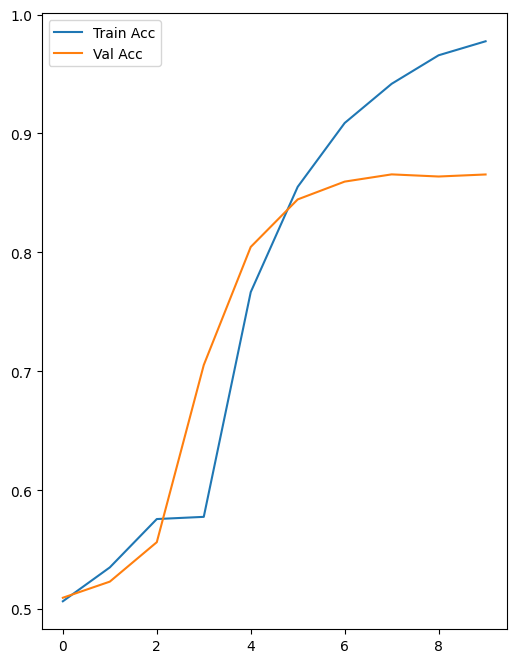

In [61]:
# plot acc
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_acc'], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'], label='Val Acc')
plt.legend()
plt.show()

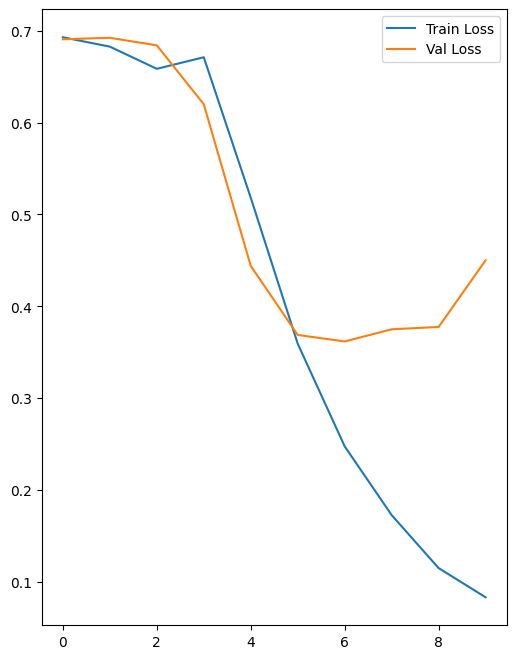

In [62]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [63]:
# test loop
model.eval()

# metrics
test_loss = 0
test_acc = 0

all_target = []
all_predicted = []

testloop = tqdm(testloader, leave=True, desc='Inference')
with torch.no_grad():
    for feature, target in testloop:
        feature, target = feature.to(device), target.to(device)

        out = model(feature)
        
        predicted = torch.tensor([1 if i == True else 0 for i in out > 0.5], device=device)
        equals = predicted == target
        acc = torch.mean(equals.type(torch.FloatTensor))
        test_acc += acc.item()

        loss = criterion(out.squeeze(), target.float())
        test_loss += loss.item()

        all_target.extend(target.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print(f'Accuracy: {test_acc/len(testloader):.4f}, Loss: {test_loss/len(testloader):.4f}')

Inference: 100%|██████████| 59/59 [00:01<00:00, 29.59it/s]

Accuracy: 0.8678, Loss: 0.4297


In [64]:
torch.save(model, 'model.pth')